In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import seaborn as sns
sns.set_style('white')
sns.set_context("poster") #[poster, paper, talk, notebook]

import warnings; warnings.simplefilter('ignore') #not the best, but helps when zeros are out of hand

#### load lidar data

In [11]:
fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' #BSU
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds['snow'] = ds.snow/10 #convert to cm
ds['snow'] = ds.snow.where(ds.snow>0) #all snow >= zero
ds.x.attrs['long_name']='Easting'; ds.x.attrs['units']='m'
ds.y.attrs['long_name']='Northing'; ds.y.attrs['units']='m'
ds.close()

#### load terrain data

In [12]:
fname = '~/Documents/research/sierra/data/20m_analysis/terrain.nc' #BSU
ts = xr.open_dataset(fname,  chunks={'x':1000,'y':1000}).drop(('dem','veg'))
ts.close()

#### do stuff

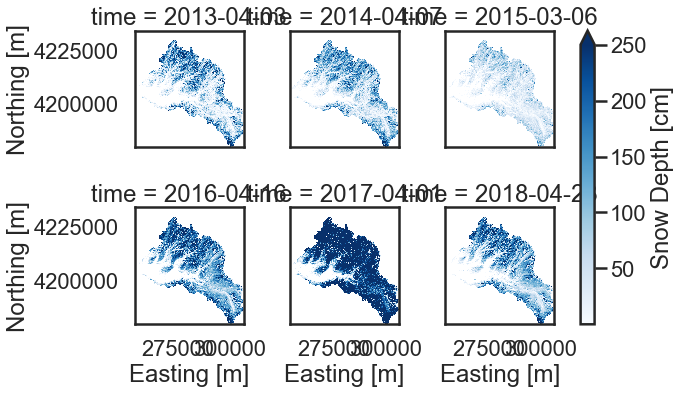

In [13]:
peak = [0,7,18,30,42,49]
ds_tmp = ds.isel(time=peak)
h = ds_tmp.snow.plot.imshow(x='x', y='y', col='time', col_wrap=3, cmap='Blues', vmax=250, cbar_kwargs={'label': 'Snow Depth [cm]'})
# plt.savefig('../figs/test.png', dpi=300)
del ds_tmp

In [14]:
#standardize
stan = (ds.snow - ds.snow.mean(dim=('x','y'))) / ds.snow.std(dim=('x','y'))
stan

<xarray.DataArray 'snow' (time: 51, y: 2739, x: 2637)>
dask.array<truediv, shape=(51, 2739, 2637), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 254000.0 254020.0 254040.0 ... 306700.0 306720.0
  * y        (y) float32 4234060.0 4234040.0 4234020.0 ... 4179320.0 4179300.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>

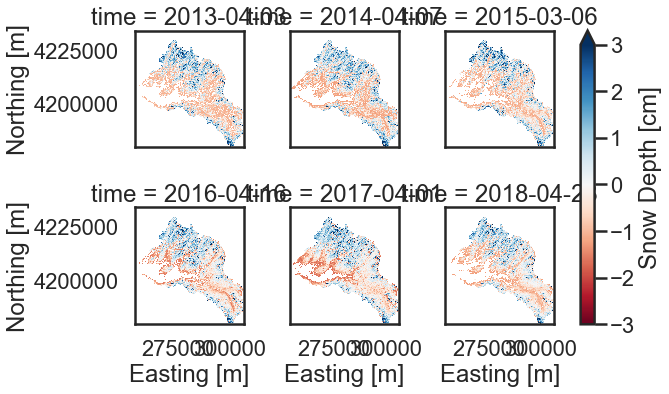

In [15]:
ds_tmp = stan.isel(time=peak)
h = ds_tmp.plot.imshow(x='x', y='y', col='time', col_wrap=3, cmap='RdBu', vmin=-3, vmax=3, cbar_kwargs={'label': 'Snow Depth [cm]'})
# plt.savefig('../figs/test.png', dpi=300)

In [ ]:
# #compute stats from xarray
# x_gt0 = ds.snow.where(ds.snow>0) #already happens when data are loaded in
# x_gt0 = ds.snow.where(ds.dem>2000)
# mu_gt0 = x_gt0.mean(dim=('x', 'y'))
# sig_gt0 = x_gt0.std(dim=('x', 'y'))

# #rescaled
# # rescaled = (x_gt0 / mu_gt0)

# #standardize
# stdize = ((x_gt0 - mu_gt0) / sig_gt0)
# stdize
# print(sig_gt0.min().values)

In [ ]:
stdize_ = stdize.isel(time=slice(1,51,2)) 
h = stdize_.plot.imshow(x='x', y='y', col='time', col_wrap=5, cmap='RdBu', vmin=-3, vmax=3, cbar_kwargs={'label': 'Standardized depth values'})

In [16]:
#standardize
# s = stdize.std(dim='time')
s = stan.std(dim='time')

In [17]:
ss = s.values
print(type(ss))

<class 'numpy.ndarray'>


In [18]:
print('min:', np.min(ss))
print('max:', np.max(ss))
print('mean:', np.mean(ss))

min: nan
max: nan
mean: nan


In [ ]:
sb = np.where(ss>=1, 1, np.nan)
np.nanmean(sb)

In [ ]:
foo = np.array([[3,4],[5,6]])
foo

boo = np.where(foo>=4, 4, np.nan)
boo

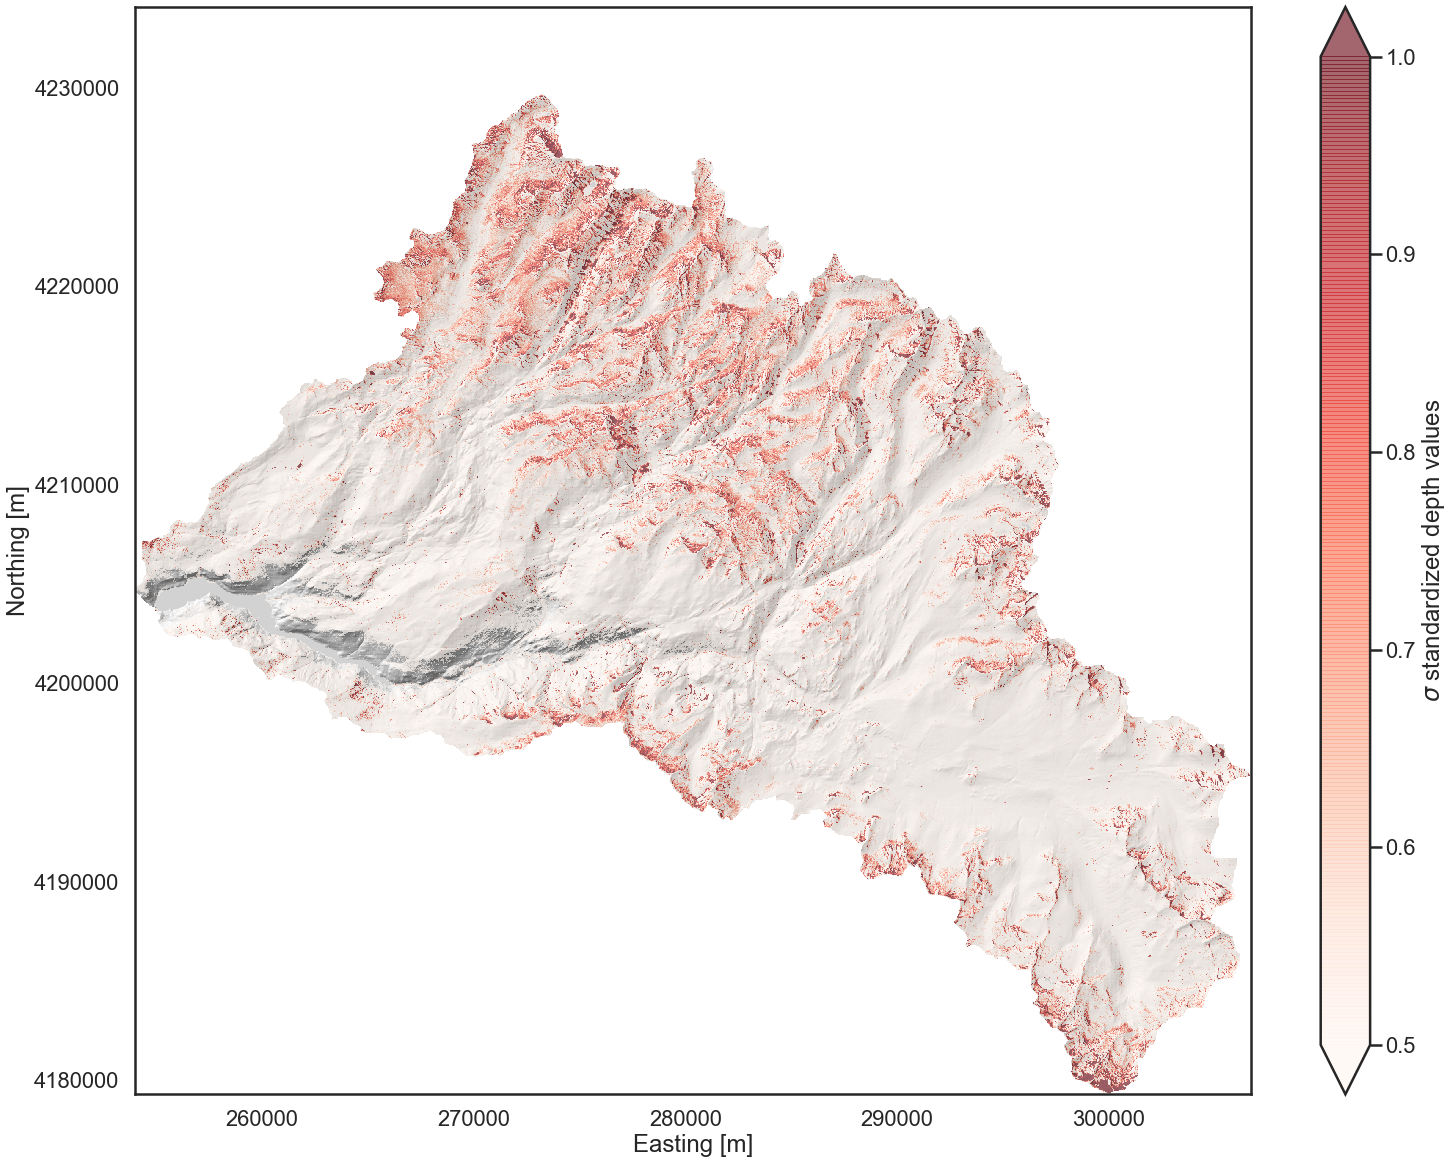

In [38]:
#plot standardize
plt.figure(figsize=(25,20))
ts.hillshade.plot.imshow(x='x', y='y', cmap='gray', alpha=.6, add_colorbar=False)
# plt.imshow(sb, cmap='Reds_r')
s.plot.imshow(x='x', y='y', cmap='Reds', alpha=.6, vmin= 0.5, vmax=1, cbar_kwargs={'label': '$\sigma$ standardized depth values'})
plt.savefig('../figs/sig_std_20m.png', dpi=300)

In [39]:
#subdomain of GRAY and RED Sdt of SDV
d = ds.sel(x=slice(270000, 280000), y=slice(4220000, 4210000)) #snow depth
t = ts.sel(x=slice(270000, 280000), y=slice(4220000, 4210000)) #terrain
d_stan = s.sel(x=slice(270000, 280000), y=slice(4220000, 4210000))

In [28]:
d

<xarray.Dataset>
Dimensions:  (time: 51, x: 501, y: 501)
Coordinates:
  * x        (x) float32 270000.0 270020.0 270040.0 ... 279980.0 280000.0
  * y        (y) float32 4220000.0 4219980.0 4219960.0 ... 4210020.0 4210000.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(297, 200), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(297, 200), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(297, 200), meta=np.ndarray>
Data variables:
    snow     (time, y, x) float64 dask.array<chunksize=(1, 297, 200), meta=np.ndarray>

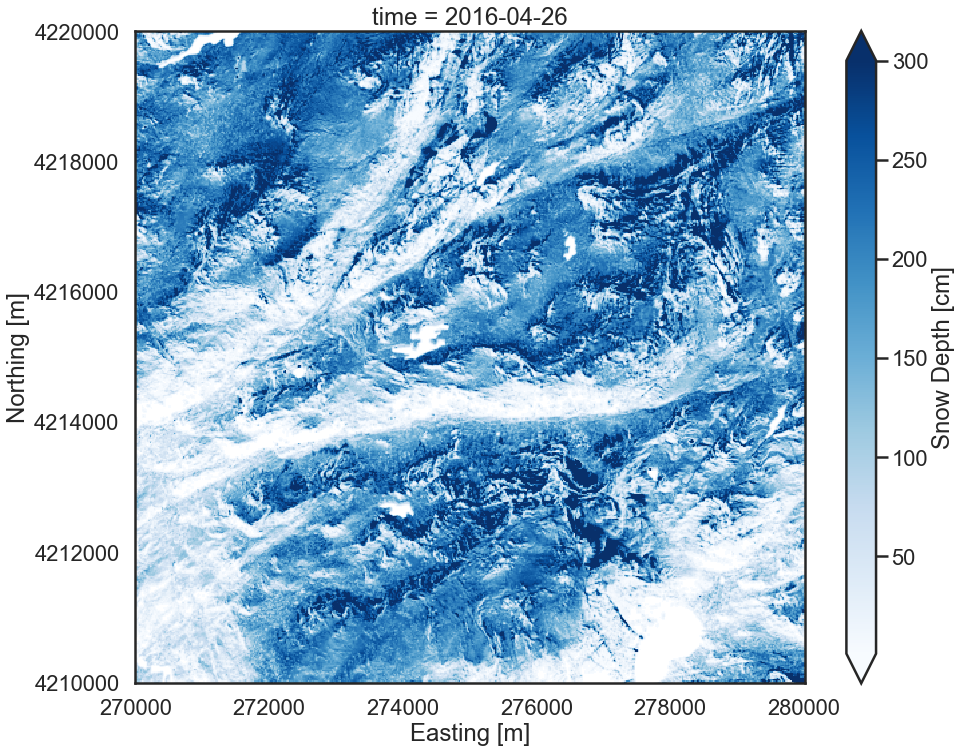

In [40]:
#plot standardize subdomain
plt.figure(figsize=(15,12))
# t.hillshade.plot.imshow(x='x', y='y', cmap='gray', alpha=.6, add_colorbar=False)
d.snow[31].plot.imshow(x='x', y='y', cmap='Blues', vmin= 300, vmax=1, cbar_kwargs={'label': 'Snow Depth [cm]'})


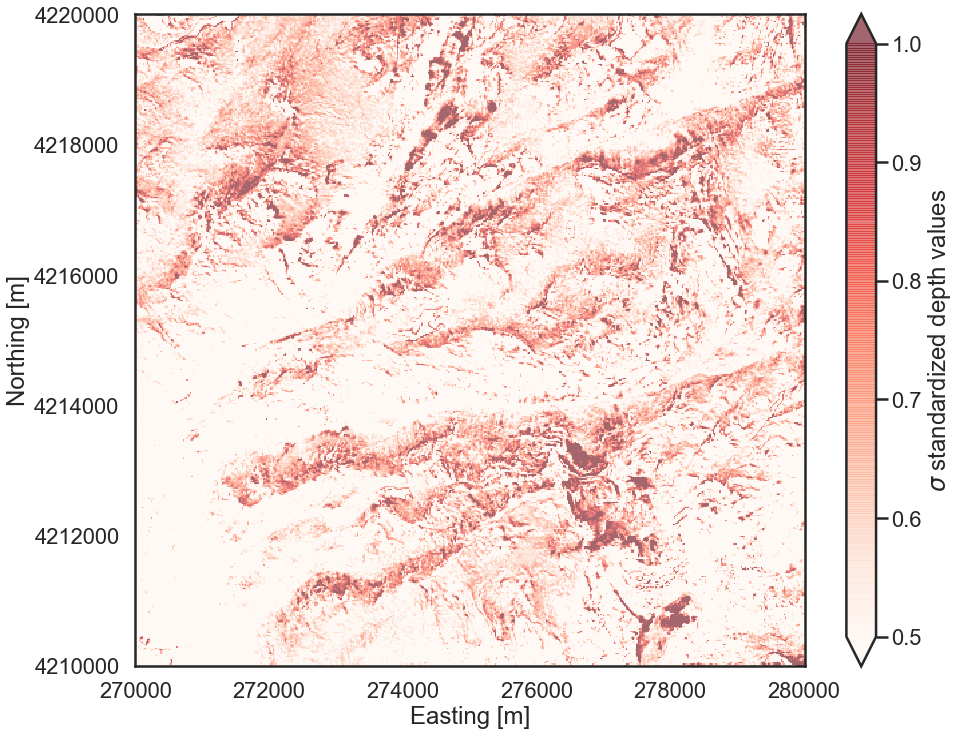

In [42]:
plt.figure(figsize=(15,12))
d_stan.plot.imshow(x='x', y='y', cmap='Reds', alpha=.6, vmin= 0.5, vmax=1, cbar_kwargs={'label': '$\sigma$ standardized depth values'})
plt.savefig('../figs/sig_std_subdom_20m.png', dpi=300)

In [ ]:
#hexbin sigma
s_flat = s.values.flatten()
e_flat = ds.dem.values.flatten()
s_flat = np.where(s_flat>0, s_flat, np.nan)
e_flat = np.where(e_flat>0, e_flat, np.nan)
print(s_flat.shape, e_flat.shape)

In [ ]:
plt.figure(figsize=(15,10))
plt.hexbin(e_flat, s_flat, mincnt=50, gridsize=250, cmap='viridis')
plt.xlabel('Elevation [m]')
plt.ylabel('$\sigma$ of SDV')
plt.title('Standard Deviation over time by Elevation')
plt.colorbar(label='frequency')
plt.ylim(0,3)
plt.savefig('../figs/sig_hexbin_el_20m', dpi=300)

In [ ]:
#aspect
a_flat = ts.aspect.values.flatten()
print(s_flat.shape, a_flat.shape)

In [ ]:
plt.figure(figsize=(15,10))
plt.hexbin(a_flat, s_flat, mincnt=50, gridsize=250, cmap='viridis')
plt.xlabel('Aspect')
plt.ylabel('$\sigma$ of SDV')
plt.title('Standard Deviation over time by Aspect')
plt.colorbar(label='frequency')
plt.ylim(0,3)
plt.savefig('../figs/sig_hexbin_as_20m', dpi=300)

In [ ]:
#slope
slp_flat = ts.slope.values.flatten()
print(s_flat.shape, slp_flat.shape)

In [ ]:
plt.figure(figsize=(15,10))
plt.hexbin(slp_flat, s_flat, mincnt=50, gridsize=250, cmap='viridis')
plt.xlabel('Slope')
plt.ylabel('$\sigma$ of SDV')
plt.title('Standard Deviation over time by Slope')
plt.colorbar(label='frequency')
plt.ylim(0,3)
plt.savefig('../figs/sig_hexbin_sl_20m', dpi=300)

In [ ]:
mu_time = stdize.mean(dim='time')
m_flat = mu_time.values.flatten()
print(e_flat.shape, m_flat.shape)

In [ ]:
#mean SDV by elevation
plt.figure(figsize=(15,10))
plt.scatter(e_flat[::100], a_flat[::100], c=m_flat[::100], s=10, cmap='jet', vmax=3)
plt.xlabel('Elevation [m]')
plt.ylabel('Aspect')
# plt.title('Mean SDV by Elevation')
plt.colorbar(label='SDV')
# plt.ylim(0,3)
# plt.savefig('../figs/meanSDV_elev_asp_20m', dpi=300)

In [ ]:
muu_time = ds.snow.mean(dim='time')
mm_flat = muu_time.values.flatten()
print(e_flat.shape, mm_flat.shape)

In [ ]:
#meanSD by aspect and elevation
plt.figure(figsize=(15,10))
plt.scatter(e_flat, a_flat, c=mm_flat, s=10, cmap='jet', vmax=250)
plt.xlabel('Elevation [m]')
plt.ylabel('Aspect')
# plt.title('Mean SDV by Elevation')
plt.colorbar(label='Mean Snow Depth [cm]')

plt.savefig('../figs/meanSD_elev_asp_20m', dpi=300)

In [ ]:
#meanSD by slope and elevation
plt.figure(figsize=(15,10))
plt.scatter(e_flat, slp_flat, c=mm_flat, s=10, cmap='jet', vmax=250)
plt.xlabel('Elevation [m]')
plt.ylabel('Slope')
# plt.title('Mean SDV by Elevation')
plt.colorbar(label='Mean Snow Depth [cm]')

plt.savefig('../figs/meanSD_elev_slp_20m', dpi=300)

In [ ]:
#mean snow depth by slope and aspect
plt.figure(figsize=(15,10))
plt.scatter(a_flat, slp_flat, c=mm_flat, s=10, cmap='jet', vmax=250)
plt.xlabel('Aspect')
plt.ylabel('Slope')
# plt.title('Mean SDV by Elevation')
plt.colorbar(label='Mean Snow Depth [cm]')

plt.savefig('../figs/meanSD_asp_slp_20m', dpi=300)

In [ ]:
stdize

#### groupby testing

In [ ]:
ds

In [ ]:
stan

In [ ]:
ds.groupby('time.year').groups

In [ ]:
# list(ds.groupby('time.year'))

### group elevation bins in ds.dem

In [ ]:
bin_sz = 250
bins = np.arange(1500, 4000, bin_sz)
bin_labels = ['1500-1750','1750-2000','2000-2250','2250-2500','2500-2750','2750-3000','3000-3250','3250-3500','3500-3750'] #do better
elev=ds.groupby_bins(group='dem', bins=bins, labels=bin_labels).groups

In [ ]:
print(type(elev))

In [ ]:
sno = ds['snow'] #make a data array
sno=sno.astype(np.int16, copy=False) #back to int16
sno

In [ ]:
sno.groupby('time').mean().values#.plot(col='time', col_wrap=3)

In [ ]:
#~~~~~ CLOSEST YET!! ~~~~~ grabs meanSD for each elevation bin......just need to add a time dimension
w = sno.groupby_bins('dem', bins, bin_labels).mean() #.mean(dim='time')

In [ ]:
w.values

In [ ]:
# for layer in list(elev):
#     print(layer)
    
for label, group in ds.groupby('time.year'):
    print(label)
#     print(group)


In [ ]:
snow_el_grp = sno.mean(['time']).groupby_bins('dem', bins, bin_labels) #snow_el_grp = sno.mean([('x','y')]).groupby_bins('dem', bins, bin_labels) # SHOULDN'T BE TAKING THE MEAN OVER TIME


In [ ]:
snow_el_grp.plot()
# print(type(snow_el_grp))

In [ ]:
snow_el_grp.plot()

In [ ]:
ds.dem.plot()

### dummy ds

In [ ]:
bla = xr.Dataset({"foo": (("x", "y"), np.random.rand(4, 3))},coords={"x": [10, 20, 30, 40], "letters": ("x", list("abba"))})
bla

In [ ]:
arr = bla["foo"]
print(type(arr))